In [1]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
%matplotlib inline
import os
import math
import pandas as pd
from scipy import optimize

# Leo las redes

In [13]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data


APMS = ldata('yeast_AP-MS.txt')
Y2H=ldata('yeast_Y2H.txt')
LIT=ldata('yeast_LIT.txt')
LIT_R=ldata('yeast_LIT_Reguly.txt')


def grafo(datosRed):
    G = nx.Graph()
    for i in range(np.shape(datosRed)[0]):
        G.add_edges_from([(datosRed[i][0],datosRed[i][1])])
    return G

GAPMS = grafo(APMS)
GY2H=grafo(Y2H)
GLIT=grafo(LIT)
GLIT_R=grafo(LIT_R)

ESENCIALIDAD DE LOS NODOS

In [14]:
essentiality=ldata('Essential.txt')

ess=[]
for i in range(len(essentiality)):
    ess.append(essentiality[i][1])
    
def essentiality(nodo): 
    if len({nodo}.intersection(set(ess)))==0:
        e=0
    else:
        e=1
    return e    

def AssignEssentiality(G):
    dict_ess = { nodo: essentiality(nodo) for nodo  in G.nodes() }
    for n in G.nodes:
        G.nodes[n]["essentiality"] = dict_ess[n]
    return

def NodosEsenciales(G):
    AssignEssentiality(G)
    nodosesenciales=[]
    for nodo in list(set(G.nodes())):
        if G.nodes.data("essentiality")[nodo]==1:
            nodosesenciales.append(nodo)
    return(nodosesenciales)

# i) Fraccion de nodos esenciales por grado

In [15]:
def fracessk(G):
    
    deg=[degree for node,degree in list(G.degree())]
    deg=list(set(deg))
    listin=[[degree,name] for (name, degree) in list(G.degree())]
    nodosesenciales=NodosEsenciales(GAPMS)
    ntot=np.zeros(len(deg),dtype=int)
    ness=np.zeros(len(deg),dtype=int)
    index=0

    for k in deg:
        for i in range(len(listin)):
            if listin[i][0]==k:
                ntot[index]=ntot[index]+1
                
                if (len({listin[i][1]}.intersection(set(nodosesenciales)))==1):
                    ness[index]=ness[index]+1    
        index=index+1    
                    
    fraccion_nodos_ess=ness/ntot
    deg_array=np.array(deg)
    
    return deg_array,fraccion_nodos_ess

In [16]:
degrees_APMS,frac_APMS=fracessk(GAPMS)
degrees_Y2H,frac_Y2H=fracessk(GY2H)
degrees_LIT,frac_LIT=fracessk(GLIT)
degrees_LIT_R,frac_LIT_R=fracessk(GLIT_R)

/home/juani/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


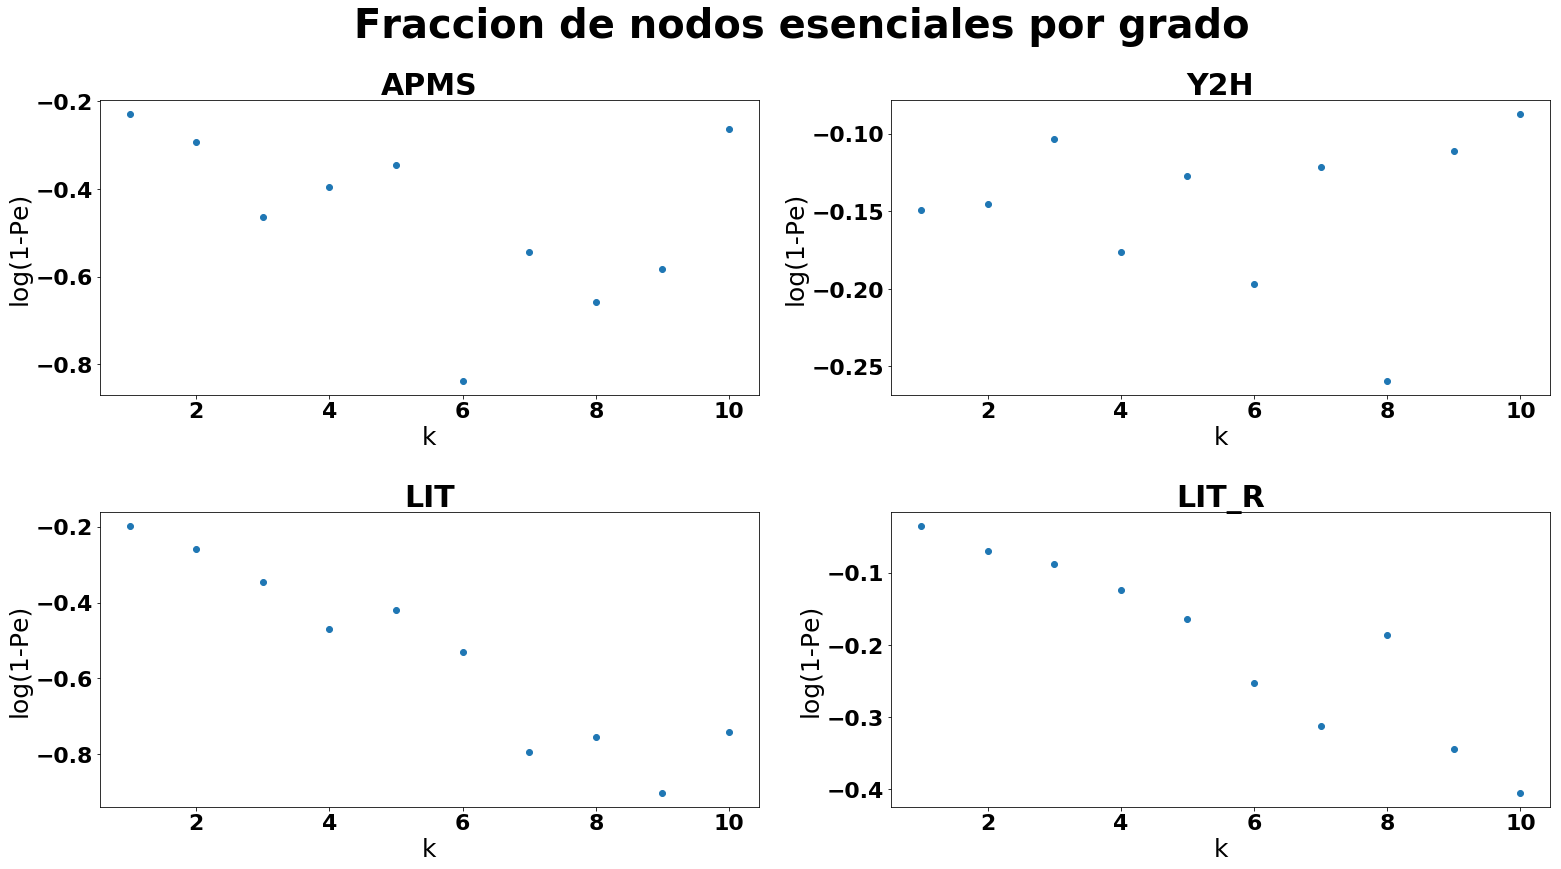

In [56]:


f = plt.figure(figsize=(26,13))
f.suptitle('Fraccion de nodos esenciales por grado',fontweight="bold", size=40) 
sub1 = f.add_subplot(221)
plt.plot(degrees_APMS[0:10],np.log(1-frac_APMS[0:10]),'.', markersize=12)
sub2 = plt.subplot(222)
plt.plot(degrees_Y2H[0:10],np.log(1-frac_Y2H[0:10]),'.', markersize=12)
sub3 = plt.subplot(223)
plt.plot(degrees_LIT[0:10],np.log(1-frac_LIT[0:10]),'.', markersize=12)
sub4 =plt.subplot(224)
plt.plot(degrees_LIT_R[0:10],np.log(1-frac_LIT_R[0:10]),'.', markersize=12)

plt.rcParams.update({'font.size': 22})
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)

sub1.set_title('APMS',fontweight="bold", size=30),sub1.set_xlabel('k',fontsize=25),sub1.set_ylabel('log(1-Pe)',fontsize=25)
sub2.set_title('Y2H',fontweight="bold", size=30),sub2.set_xlabel('k',fontsize=25),sub2.set_ylabel('log(1-Pe)',fontsize=25)
sub3.set_title('LIT',fontweight="bold", size=30),sub3.set_xlabel('k',fontsize=25),sub3.set_ylabel('log(1-Pe)',fontsize=25)
sub4.set_title('LIT_R',fontweight="bold", size=30),sub4.set_xlabel('k',fontsize=25),sub4.set_ylabel('log(1-Pe)',fontsize=25)
plt.show()

# AJUSTE LINEAL

In [71]:
m_APMS, b_APMS = np.polyfit(degrees_APMS[0:10],np.log(1-frac_APMS[0:10]), 1)
m_Y2H, b_Y2H = np.polyfit(degrees_Y2H[0:10],np.log(1-frac_Y2H[0:10]), 1)
m_LIT, b_LIT = np.polyfit(degrees_LIT[0:10],np.log(1-frac_LIT[0:10]), 1)
m_LIT_R, b_LIT_R = np.polyfit(degrees_LIT_R[0:10],np.log(1-frac_LIT_R[0:10]), 1)

alpha_APMS=1-np.exp(m_APMS)
beta_APMS=1-np.exp(b_APMS)

alpha_Y2H=1-np.exp(m_Y2H)
beta_Y2H=1-np.exp(b_Y2H)

alpha_LIT=1-np.exp(m_LIT)
beta_LIT=1-np.exp(b_LIT)

alpha_LIT_R=1-np.exp(m_LIT_R)
beta_LIT_R=1-np.exp(b_LIT_R)

# ii) cuantos pares de nodos con al menos 3 vecinos en comun y no enlazados

In [72]:
def TotalYFraccionPares(G):
    nodes=list(G.nodes())
    N=len(G.nodes())
    A=nx.to_numpy_matrix(G)
    Acuadrado=np.matmul(A,A)
    ParesTotal=[]
    for i in range(N):
        for j in range(i+1,N):
            if (A[i,j]==0 and Acuadrado[i,j]>=3):
                ParesTotal.append([nodes[i],nodes[j]])
    Numero_Pares_Total=len(ParesTotal)
    
    nodosesenciales=NodosEsenciales(G)
    ParesIguales=[]
    
    for i in range(Numero_Pares_Total):
        if ( len({ParesTotal[i][0]}.intersection(set(nodosesenciales)))==1 and len({ParesTotal[i][1]}.intersection(set(nodosesenciales)))==1):
            ParesIguales.append(ParesTotal[i])
        if ( len({ParesTotal[i][0]}.intersection(set(nodosesenciales)))==0 and len({ParesTotal[i][1]}.intersection(set(nodosesenciales)))==0):
            ParesIguales.append(ParesTotal[i])
    
    Numero_Pares_Iguales=len(ParesIguales)
    
    return(ParesTotal,Numero_Pares_Total,Numero_Pares_Iguales)

In [73]:
ParesTotalAPMS,NumeroParesTotalAPMS,NumeroParesIgualesAPMS=TotalYFraccionPares(GAPMS)
ParesTotalY2H,NumeroParesTotalY2H,NumeroParesIgualesY2H=TotalYFraccionPares(GY2H)
ParesTotalLIT,NumeroParesTotalLIT,NumeroParesIgualesLIT=TotalYFraccionPares(GLIT)
ParesTotalLIT_R,NumeroParesTotalLIT_R,NumeroParesIgualesLIT_R=TotalYFraccionPares(GLIT_R)

AHORA CALCULO LA PROBABILIDAD CON EL ALPHA Y EL BETA

$$P_E= 1-(1-\alpha)^k (1-\beta)$$

In [77]:
def ParesEsperados(G,ParesTotal,alpha,beta):
    degree=dict(G.degree())
    
    ParesDegree=[]
    for i in range(len(ParesTotal)):
        ParesDegree.append([degree[ParesTotal[i][0]],degree[ParesTotal[i][1]]])
    
    PD=np.array(ParesDegree)
    PE=1-(1-alpha)**PD *(1-beta)
    PNE=1-PE #jaja

    Pares_esperados= (PE[:,0]*PE[:,1]).sum() + (PNE[:,0]*PNE[:,1]).sum()
    
    return Pares_esperados

In [83]:
expectedAPMS=int(ParesEsperados(GAPMS,ParesTotalAPMS,alpha_APMS,beta_APMS))
expectedY2H=int(ParesEsperados(GY2H,ParesTotalY2H,alpha_Y2H,beta_Y2H))
expectedLIT=int(ParesEsperados(GLIT,ParesTotalLIT,alpha_LIT,beta_LIT))
expectedLIT_R=int(ParesEsperados(GLIT_R,ParesTotalLIT_R,alpha_LIT_R,beta_LIT_R))

In [84]:
expectedAPMS,expectedY2H,expectedLIT,expectedLIT_R

(6430, 403, 373, 5532)

# RESULTADOS

In [85]:
 from IPython.display import HTML, display

 data = [["RED","PARES TOTALES","PARES DEL MISMO TIPO","PARES ESPERADOS"],
         ["APMS",NumeroParesTotalAPMS, NumeroParesIgualesAPMS, expectedAPMS],
         ["Y2H",NumeroParesTotalY2H, NumeroParesIgualesY2H, expectedY2H],
         ["LIT",NumeroParesTotalLIT,NumeroParesIgualesLIT,expectedLIT],
         ["LIT_R",NumeroParesTotalLIT_R, NumeroParesIgualesLIT_R, expectedLIT_R],
         ]

 display(HTML(
    '<table><tr>{}</tr></table>'.format(
        '</tr><tr>'.join(
            '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in data)
        )
 ))

RED,PARES TOTALES,PARES DEL MISMO TIPO,PARES ESPERADOS
APMS,11613,5907,6430
Y2H,522,352,403
LIT,730,389,373
LIT_R,10777,6187,5532
